## Part 3 - Analyse the Land Use Changes
#### Notebook outline:

This notebook outlines the analysis of vegetation classes and changes to other land uses. 

This function requires the following libraries:

In [3]:
import rasterio
import xarray as xr

import rioxarray as rio
from rasterio.plot import show
from rasterio.windows import from_bounds

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  matplotlib.cm import ScalarMappable
from  matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

##### Function:
This function calculates the area in km2 for each vegetation class within the sample site

In [48]:
def vegetation_area_analysis_area(start_year,end_year,sample_site,site_x_origin,site_y_origin,site_size):

    
    """
    
    This function creates an output of area calculations for each vegetation class for the sample site defined. 
    
    start_year = first year to calculate areas for
    end_year = final year to calculate areas for
    sample_site = sample site name for file naming
    site_x_origin = bottom left x-coordinate of sample site in geographic coordinates
    site_y_origin = bottom left y-coordinate of sample site in geographic coordinates
    site_size = size of sample site in geographic coordinates
    
    Datasources:
    
    1. The vegetation raster data is extracted from https://code.earthengine.google.com/?scriptPath=users%2Fmapbiomas%2Fuser-toolkit%3Amapbiomas-user-toolkit-lulc.js
    2. Legend codes for vegetation classes were taken from https://s3.amazonaws.com/amazonia.mapbiomas.org/leyenda/C%C3%B3digo_de_la_Leyenda_-_colecci%C3%B3n_4.pdf
    

    """
    
    year = start_year
    
    # Download the colour codes for vegetation classes - extract from a saved CSV file

    colorCode = pd.read_csv('Colour Codes for Vegetation.csv')
    colorCode.drop(columns=['ClassesBR'],inplace=True)
    colorCode
    
    # Extract original colours
    sortColor = colorCode.sort_values('ID')

    vals = sortColor['ID'].values
    cols = sortColor['HexCode'].values
    bounds = np.append(vals, vals[-1] + 1)

    cmap = ListedColormap(cols)
    norm = BoundaryNorm(bounds, ncolors=len(cols))

    
    while year <= end_year:

        #Loading in the dataset

        ds = rio.open_rasterio("https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_8/lclu/coverage/brasil_coverage_"+str(year)+".tif")


        # Slice to the sample site

        ds_clip = ds.sel(x=slice(site_x_origin,(site_x_origin + site_size)),y=slice((site_y_origin + site_size),site_y_origin)).isel(band=0)


        # Counting the area for the each vegetation class

        totalArea = (111*site_size)**2 # in km2 - assumes 1 degree of longititude and latitude is the same and near the equator it is about 111km
        totalPix = ds_clip.size # number on pixel for the clipped dataset

        count = []
        for k in range(len(colorCode)):
            classID = colorCode['ID'].values[k]
            count.append(ds_clip.where(ds_clip==classID).count().values+0)

        colorCode['count'] = count
        colorCode['perc'] = np.round(((np.asarray(count)/totalPix)*100),3)
        colorCode['area_km2_'+str(year)] = colorCode['perc'].values*totalArea/100.
        vegAnalysis = colorCode.copy()
        vegAnalysis.drop(columns=['HexCode','perc', 'count', 'ID'],inplace=True)
        vegAnalysis

        year += 1
        

    # Plot to csv
    vegAnalysis.to_csv('vegetation_analysis_sample_site_area_'+str(sample_site)+'_'+str(start_year)+'-'+str(end_year)+'.csv',index=False)

    return

#### Initial vegetation calculations

In [49]:
vegetation_area_analysis_area(1985,2022,'Control Site',-69,-3,2)

In [50]:
vegetation_area_analysis_area(1985,2022,'Sample Site 1',-48,-5,2)

In [51]:
vegetation_area_analysis_area(1985,2022,'Sample Site 2',-52,-4,2)

In [52]:
vegetation_area_analysis_area(1985,2022,'Sample Site 3',-65,-10,2)

In [53]:
vegetation_area_analysis_area(1985,2022,'Sample Site 4',-58,-12,2)

#### Further vegetation class analysis

In [63]:
def vegetation_area_difference(sample_site):

    
    """
    
    This function calculates the mean of the area of each vegetation class from 1985-1999 and the difference from that mean for the year 2000-2022.
    
    sample_site = sample site name

    """

    # read input csv file
    vegdf = pd.read_csv('vegetation_analysis_sample_site_area_'+str(sample_site)+'_1985-2022.csv')

    #remove all rows without values

    vegdf = vegdf[(vegdf != 0).all(1)]

    # calculate the mean of each vegetation class from 1985-2000

    vegmean = vegdf.drop(columns=['area_km2_2000', 'area_km2_2001',
                                  'area_km2_2002', 'area_km2_2003', 
                                  'area_km2_2004', 'area_km2_2005', 
                                  'area_km2_2006', 'area_km2_2007',
                                  'area_km2_2008', 'area_km2_2009',
                                  'area_km2_2010', 'area_km2_2011', 
                                  'area_km2_2012', 'area_km2_2013', 
                                  'area_km2_2014', 'area_km2_2015',
                                  'area_km2_2016', 'area_km2_2017',
                                  'area_km2_2018', 'area_km2_2019', 
                                  'area_km2_2020', 'area_km2_2021', 'area_km2_2022'])

    vegmean['mean'] = vegmean.loc[:,['area_km2_1985', 'area_km2_1986',
                                  'area_km2_1987', 'area_km2_1988', 
                                  'area_km2_1989', 'area_km2_1990', 
                                  'area_km2_1991', 'area_km2_1992',
                                  'area_km2_1993', 'area_km2_1994',
                                  'area_km2_1995', 'area_km2_1996', 
                                  'area_km2_1997', 'area_km2_1998', 'area_km2_1999']].mean(axis=1)

    vegmean = vegmean.drop(columns=['area_km2_1985', 'area_km2_1986',
                                  'area_km2_1987', 'area_km2_1988', 
                                  'area_km2_1989', 'area_km2_1990', 
                                  'area_km2_1991', 'area_km2_1992',
                                  'area_km2_1993', 'area_km2_1994',
                                  'area_km2_1995', 'area_km2_1996', 
                                  'area_km2_1997', 'area_km2_1998', 'area_km2_1999'])

    # calculate the difference mean of each vegetation class from 1985-2000 for each year

    vegdiff = vegdf.drop(columns=['area_km2_1985', 'area_km2_1986',
                                  'area_km2_1987', 'area_km2_1988', 
                                  'area_km2_1989', 'area_km2_1990', 
                                  'area_km2_1991', 'area_km2_1992',
                                  'area_km2_1993', 'area_km2_1994',
                                  'area_km2_1995', 'area_km2_1996', 
                                  'area_km2_1997', 'area_km2_1998', 'area_km2_1999'])

    vegdiff = pd.merge(vegdiff,vegmean)
    vegdiff = vegdiff.set_index(vegdiff.columns[0])
    
    cols = ['area_km2_2000', 'area_km2_2001',
                              'area_km2_2002', 'area_km2_2003', 
                              'area_km2_2004', 'area_km2_2005', 
                              'area_km2_2006', 'area_km2_2007',
                              'area_km2_2008', 'area_km2_2009',
                              'area_km2_2010', 'area_km2_2011', 
                              'area_km2_2012', 'area_km2_2013', 
                              'area_km2_2014', 'area_km2_2015',
                              'area_km2_2016', 'area_km2_2017',
                              'area_km2_2018', 'area_km2_2019', 
                              'area_km2_2020', 'area_km2_2021', 'area_km2_2022']

    vegdiff = vegdiff.loc[:, cols].sub(vegdiff['mean'],axis=0,)

    vegdiff = vegdiff.rename(columns={'area_km2_2000' :'2000',
                                  'area_km2_2001' :'2001',
                                  'area_km2_2002' :'2002', 
                                  'area_km2_2003' :'2003', 
                                  'area_km2_2004' :'2004', 
                                  'area_km2_2005' :'2005', 
                                  'area_km2_2006' :'2006', 
                                  'area_km2_2007' :'2007',
                                  'area_km2_2008' :'2008', 
                                  'area_km2_2009' :'2009',
                                  'area_km2_2010' :'2010', 
                                  'area_km2_2011' :'2011', 
                                  'area_km2_2012' :'2012', 
                                  'area_km2_2013' :'2013', 
                                  'area_km2_2014' :'2014', 
                                  'area_km2_2015' :'2015',
                                  'area_km2_2016' :'2016', 
                                  'area_km2_2017' :'2017',
                                  'area_km2_2018' :'2018', 
                                  'area_km2_2019' :'2019', 
                                  'area_km2_2020' :'2020', 
                                  'area_km2_2021' :'2021', 
                                  'area_km2_2022' :'2022'})
    
    # plot the graph
    vegdifftranspose = vegdiff.transpose()
    ax = vegdifftranspose.plot(kind='bar', stacked=True, legend=False, cmap ='tab20c', figsize = (10,6), title = sample_site)
    plt.legend(title='Vegetation Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('Year')
    ax.set_ylabel('Difference from mean')
    
    plt.savefig('vegetation_graph_'+str(sample_site)+'.png', bbox_inches='tight', dpi=100)
    
    return

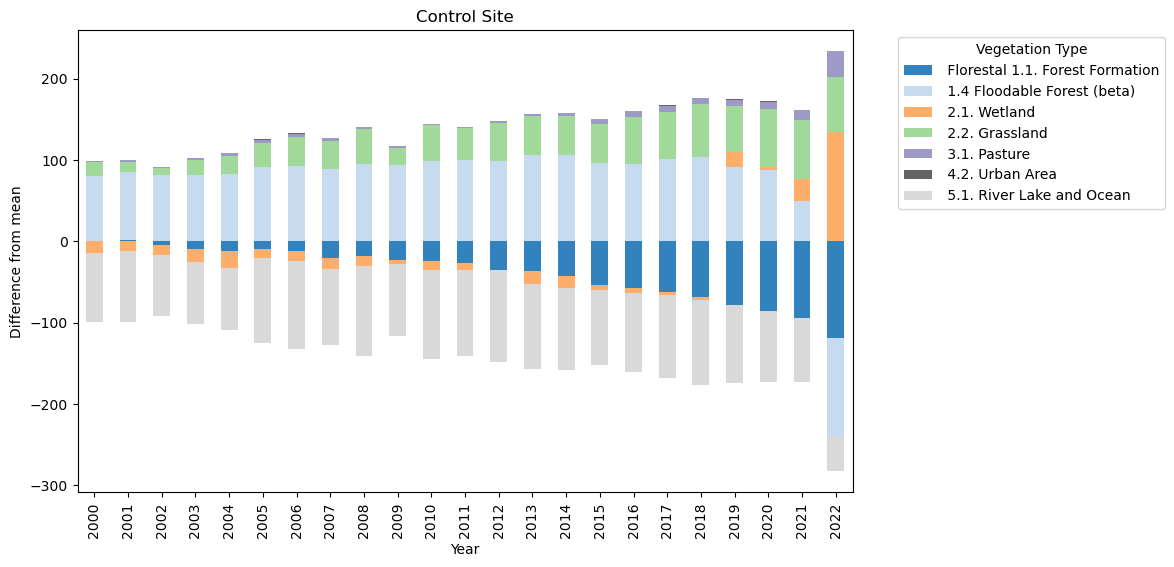

In [64]:
vegetation_area_difference('Control Site')

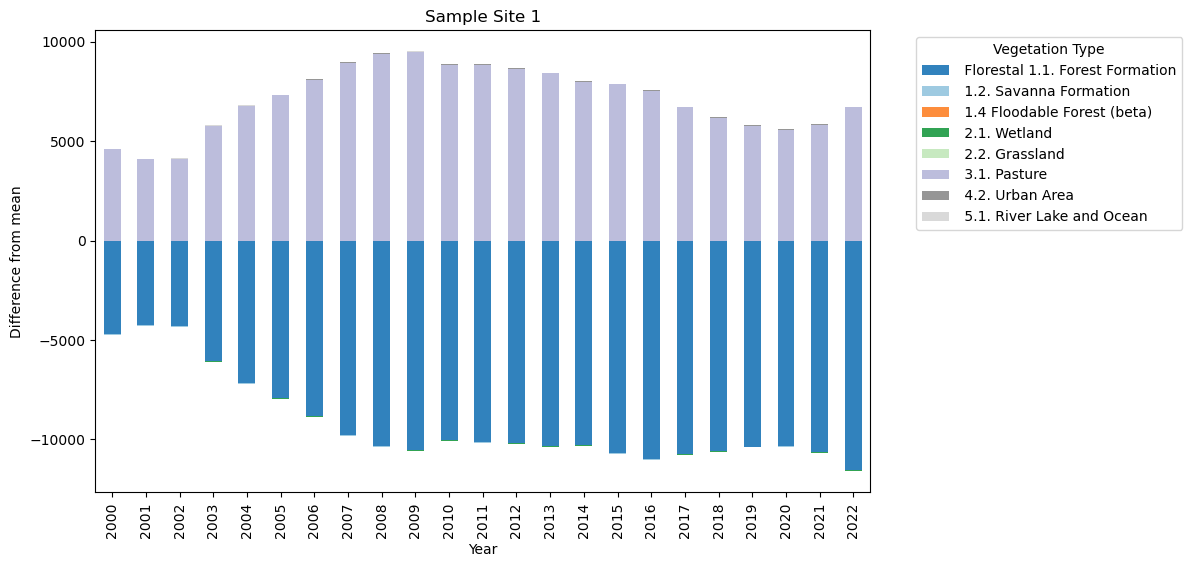

In [65]:
vegetation_area_difference('Sample Site 1')

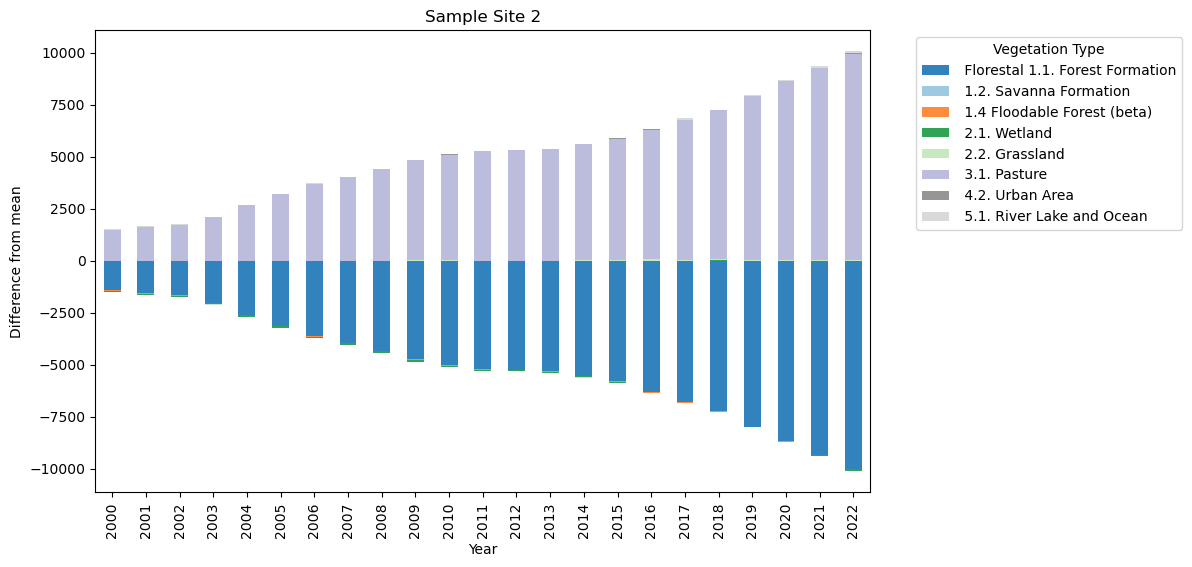

In [66]:
vegetation_area_difference('Sample Site 2')

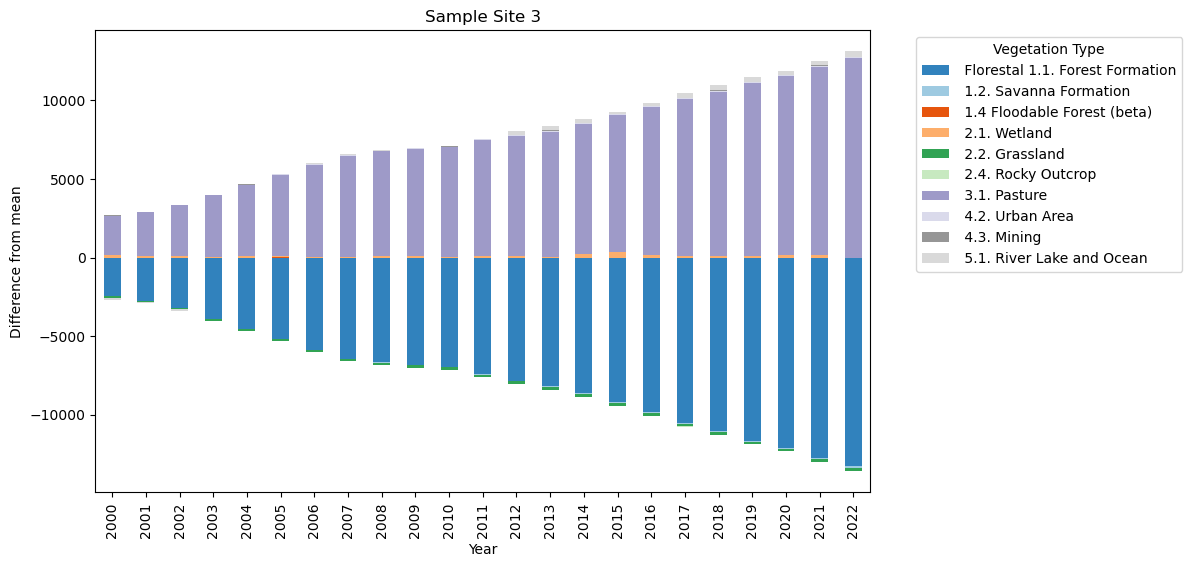

In [67]:
vegetation_area_difference('Sample Site 3')

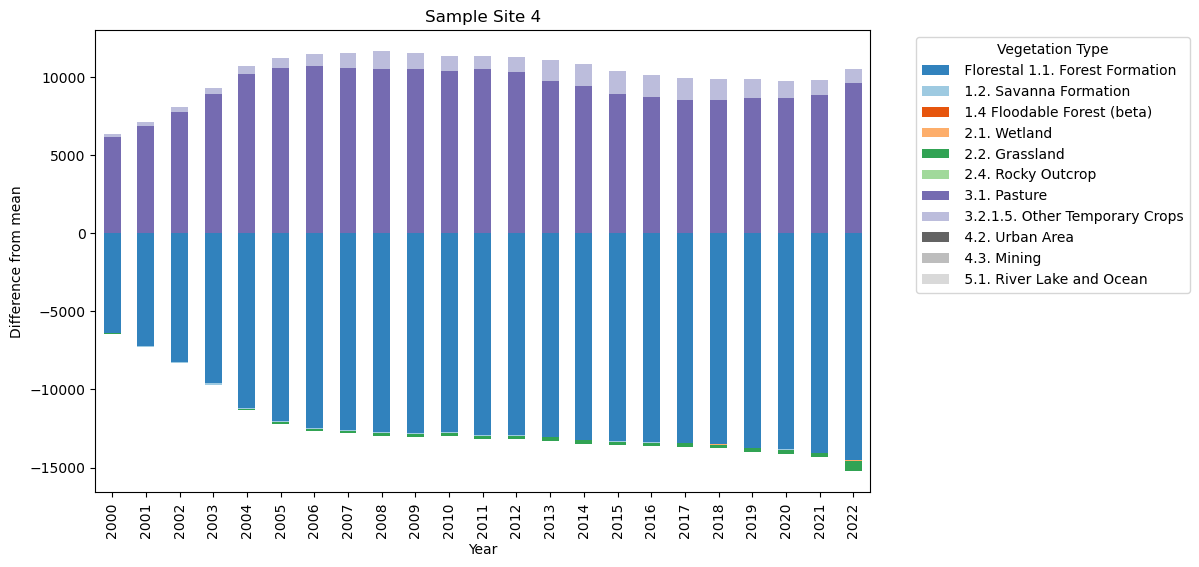

In [68]:
vegetation_area_difference('Sample Site 4')